In [1]:
from typing import Callable

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def spline_features(
    x: list[float] | np.ndarray, knots: list[float] | np.ndarray
) -> np.ndarray:
    x = np.asarray(x)
    n = x.shape[0]
    K = len(knots)
    features = np.ones((n, 3 + K))
    features[:, 1] = x
    features[:, 2] = x**2
    for j, knot in enumerate(knots):
        features[:, 3 + j] = np.maximum(0, (x - knot)) ** 2
    return features


# Shape of the data
# | 1 | x_1 | x_1^2 | (x_1 - knot_1)_+^2 | (x_1 - knot_2)_+^2 | ... | (x_1 - knot_K)_+^2 |
# |---|---|-----|-------------------|-------------------|-----|-------------------|
# | 1 | x_n | x_n^2 | (x_n - knot_1)_+^2 | (x_n - knot_2)_+^2 | ... | (x_n - knot_K)_+^2 |

In [34]:
def plot_fun(
    weights: list[float] | np.ndarray,
    features: np.ndarray,
    xs: np.ndarray,
    true_fun: Callable[[np.ndarray], np.ndarray] = None,
    interval: tuple[float, float] = (-1, 1),
    n_true: int = 200,
    data: np.ndarray = None,
    ax=None,
) -> None:
    new_fig = False
    if ax is None:
        plt.figure(figsize=(20, 8))
        ax = plt.gca()
        new_fig = True
    weights = np.atleast_2d(weights)
    if weights.shape[0] == 1:
        weight = weights[0]
        ys = features @ weight
        xs_plot = features[:, 1]
        ax.plot(xs_plot, ys, label="spline")
    else:
        for weight in weights:
            ys = features @ weight
            ax.plot(xs, ys)
            ax.scatter(xs, ys, marker="x")
    if true_fun is not None:
        x_true = np.linspace(*interval, n_true)
        y_true = true_fun(x_true)
        ax.plot(x_true, y_true, label="True function", color="black")
        if data is not None:
            ax.scatter(data[:, 0], data[:, 1], label="Data", marker="x", color="black")
    ax.legend()
    if new_fig:
        plt.show()

In [4]:
# Define two matrices L and L^{-1} that translate a vector in the first quadrant to a valid vector for a convex function
# L is a lower triangular matrix with ones on the diagonal
def L_matrix(n_knots: int) -> tuple[np.ndarray, np.ndarray]:
    L = np.tril(np.ones((n_knots + 1, n_knots + 1)))
    L_inv = np.linalg.inv(L)
    return L, L_inv

In [5]:
def create_weight(
    lin_weight: list[float] | np.ndarray, gamma: np.ndarray
) -> np.ndarray:
    n_knots = gamma.shape[0] - 1
    weight = np.zeros(3 + n_knots)
    weight[:2] = lin_weight
    L, L_inv = L_matrix(n_knots)
    weight[2:] = L_inv @ gamma
    return weight

# Training

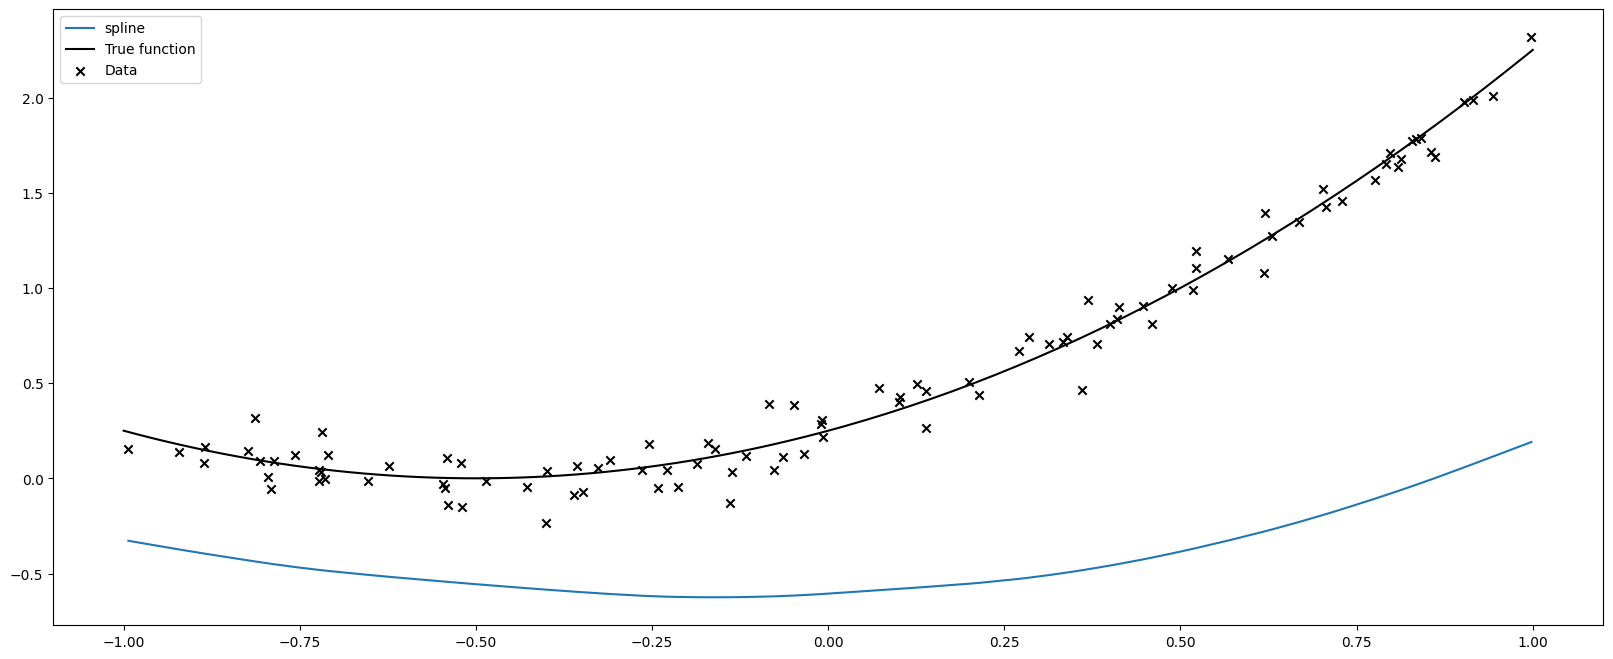

In [6]:
def quad_05(x: np.ndarray) -> np.ndarray:
    return (x - 0.5) ** 2


def quad_m05(x: np.ndarray) -> np.ndarray:
    return (x + 0.5) ** 2


def sample_data(n_data, interval, f, noise=0.1):
    xs = np.random.uniform(*interval, n_data)
    xs.sort()
    ys = f(xs) + np.random.normal(0, noise, n_data)
    return xs, ys


def sample_weight(n_knots, gamma_max, lin_max):
    gamma = np.random.uniform(0, gamma_max, n_knots + 1)
    lin_weight = np.random.uniform(-lin_max, lin_max, 2)
    weight = create_weight(lin_weight, gamma)
    return weight


n_knots = 21
knots = np.linspace(-1, 1, n_knots)
xs, ys = sample_data(100, (-1, 1), quad_m05)
features = spline_features(xs, knots)
gamma_max = 1
lin_max = 1
weight = sample_weight(n_knots, gamma_max, lin_max)
plot_fun(
    weight,
    features,
    xs,
    true_fun=quad_m05,
    data=np.column_stack((xs, ys)),
    interval=(-1, 1),
)

In [38]:
def negative_ll_and_derivative(
    y_data, features, lin_weight, gamma, index=None, value=None
):
    memory = None
    if index is not None:
        memory = gamma[index]
        gamma[index] = value
    weight = create_weight(lin_weight, gamma)
    prediction = features @ weight
    data_log_likelihood = 0.5 * np.sum((y_data - prediction) ** 2)
    if index is not None:
        gamma[index] = memory
        derivative = -np.sum((y_data - prediction) * features[:, index])
        return data_log_likelihood, derivative
    return data_log_likelihood

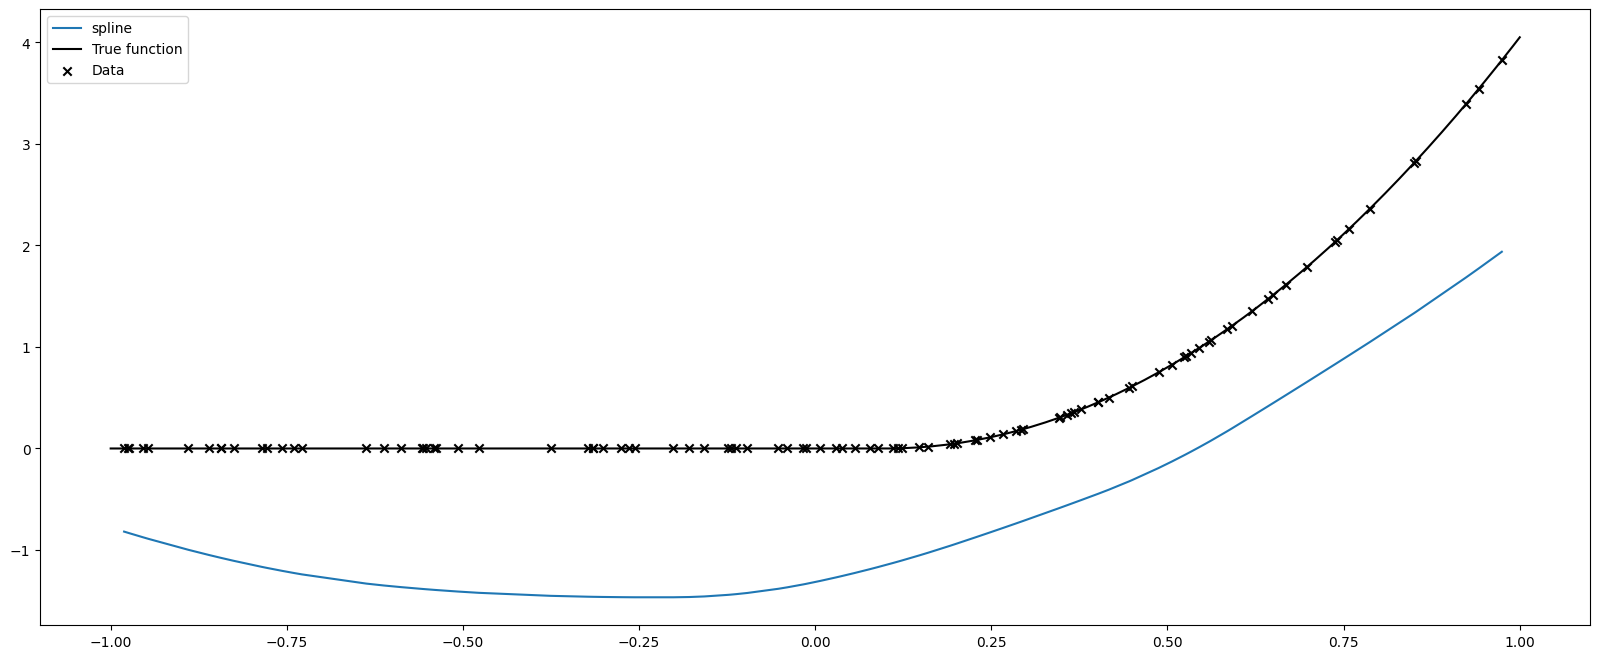

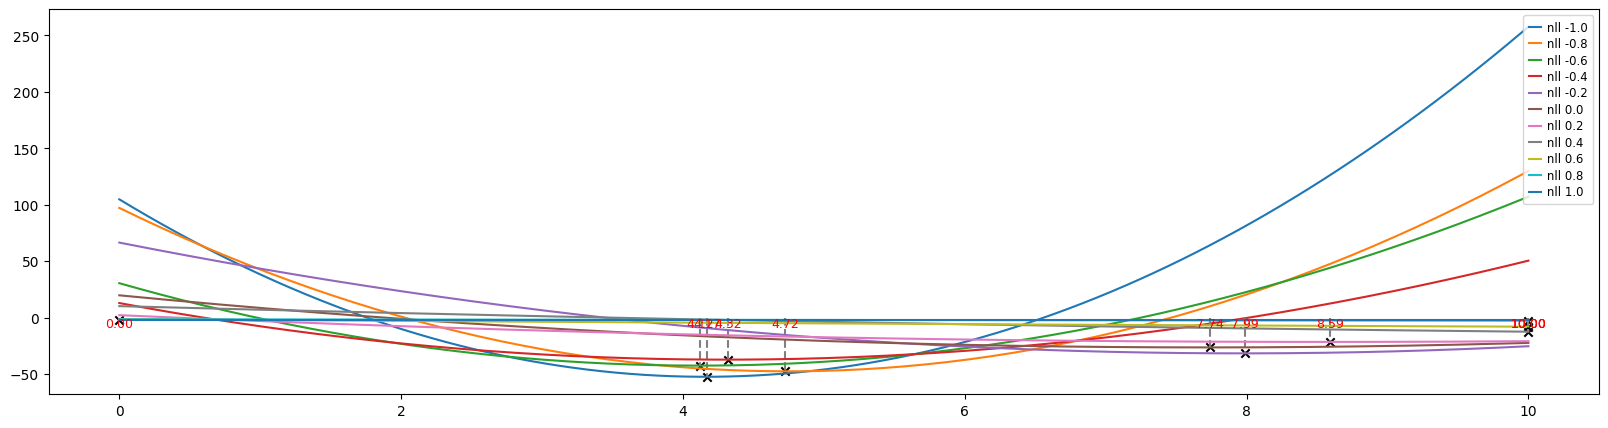

In [41]:
def q_01_postive(x: np.ndarray) -> np.ndarray:
    return 5 * np.maximum(0, x - 0.1) ** 2


lin_slice = slice(0, 2)
x2_slice = slice(2, 3)
gamma_slice = slice(3, None)

n_knots = 11
interval = (-1, 1)
v_star = np.random.exponential(scale=1)

n_data = 100
xs, ys = sample_data(n_data, interval, q_01_postive, noise=0)
knots = np.linspace(*interval, n_knots)
features = spline_features(xs, knots)
gamma_max = 5
lin_max = 5
gamma = np.random.uniform(0, gamma_max, n_knots + 1)
lin_weight = np.random.uniform(-lin_max, lin_max, 2)

##### test
# lin_weight = np.zeros_like(lin_weight)
# gamma = np.zeros_like(gamma)
# # gamma[1:] = 5
# gamma[12:] = 5
# w = create_weight(lin_weight, gamma)
# print(w[lin_slice])
# print(w[x2_slice])
# print(w[gamma_slice])
plot_fun(
    create_weight(lin_weight, gamma),
    features,
    xs,
    true_fun=q_01_postive,
    data=np.column_stack((xs, ys)),
    interval=interval,
)
# print(f"v_star: {v_star}")

base_nll = negative_ll_and_derivative(ys, features, lin_weight, gamma)
v = v_star + base_nll

grid = np.linspace(0, 10, 200)
plt.figure(figsize=(20, 5))
for knot_ind in range(1, gamma.shape[0]):
    nlls = np.zeros_like(grid)
    for j, value in enumerate(grid):
        nll, der = negative_ll_and_derivative(
            ys, features, lin_weight, gamma, index=knot_ind, value=value
        )
        nlls[j] = nll - v
    plt.plot(
        grid,
        nlls,
        label=f"nll {np.round(knots[knot_ind-1], decimals=2) if knot_ind > 0 else 'x^2'}",
        color="black" if knot_ind == 0 else None,
    )
    # scatter the minimizer for each knot
    min_index = np.argmin(nlls)
    plt.scatter(grid[min_index], nlls[min_index], color="black", marker="x")
    # add a point on x-axis for each minimizer
    plt.vlines(
        x=grid[min_index],
        ymin=0,
        ymax=nlls[min_index],
        colors="gray",
        linestyles="dashed",
    )
    # Annotate the x-value at the bottom (x-axis)
    plt.text(
        grid[min_index],
        0,
        f"{grid[min_index]:.2f}",
        horizontalalignment="center",
        verticalalignment="top",
        fontsize=9,
        color="red",
    )
plt.legend(
    loc="upper right",
    ncol=1,  # Change to more columns if needed, e.g., ncol=2
    fontsize="small",  # Smaller font size for compactness
    handlelength=1,  # Shorter line length in legend
    handletextpad=0.5,  # Reduced space between legend handle and text
    labelspacing=0.3,  # Reduced vertical spacing between entries
    borderpad=0.5,
)
plt.show()

nll_at_left:277.8752705865403 > 0 knot_ind: 0
nll_at_right:1067361.0728748506 > 0 knot_ind: 0
nll_at_right:95764.80355326307 > 0 knot_ind: 1
nll_at_right:70913.29037703761 > 0 knot_ind: 2
nll_at_right:51204.85488774068 > 0 knot_ind: 3
nll_at_right:34599.92782617452 > 0 knot_ind: 4
nll_at_right:21888.337123139605 > 0 knot_ind: 5
nll_at_right:12804.63742558693 > 0 knot_ind: 6
nll_at_right:6409.333293563005 > 0 knot_ind: 7
nll_at_right:2684.6275882060654 > 0 knot_ind: 8
nll_at_right:688.321610084745 > 0 knot_ind: 9
nll_at_right:60.52359539075974 > 0 knot_ind: 10
curr g:	 [0.48 3.80 3.42 2.41 2.44 2.74 2.71 4.42 1.30 0.42 4.36 3.92]
curr w:	 [0.48 3.32 -0.39 -1.00 0.03 0.30 -0.02 1.71 -3.12 -0.89 3.94 -0.44]
best g:	 [2.76 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
best w:	 [2.76 -2.76 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]


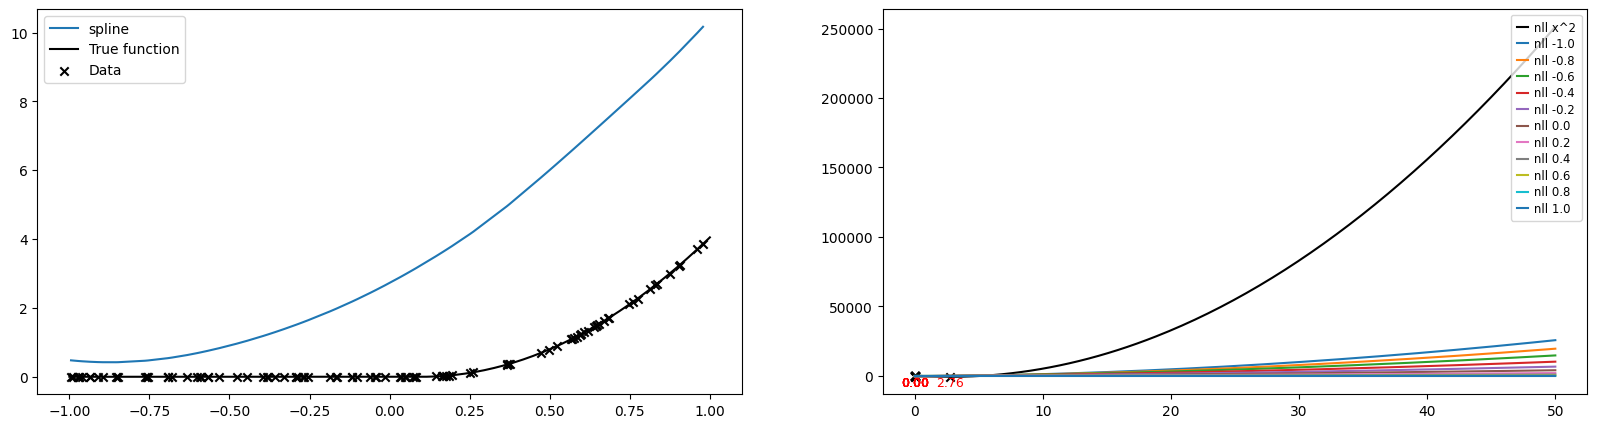

nll_at_left:278.01003158639185 > 0 knot_ind: 0
nll_at_right:1067361.2076358504 > 0 knot_ind: 0
nll_at_right:95764.93831426292 > 0 knot_ind: 1
nll_at_right:70913.42513803746 > 0 knot_ind: 2
nll_at_right:51204.98964874053 > 0 knot_ind: 3
nll_at_right:34600.06258717437 > 0 knot_ind: 4
nll_at_right:21888.471884139457 > 0 knot_ind: 5
nll_at_right:12804.772186586782 > 0 knot_ind: 6
nll_at_right:6409.468054562856 > 0 knot_ind: 7
nll_at_right:2684.762349205917 > 0 knot_ind: 8
nll_at_right:688.4563710845965 > 0 knot_ind: 9
nll_at_right:60.65835639061129 > 0 knot_ind: 10
curr g:	 [0.48 3.80 3.42 2.41 2.44 2.74 2.71 4.42 1.30 0.42 4.36 3.92]
curr w:	 [0.48 3.32 -0.39 -1.00 0.03 0.30 -0.02 1.71 -3.12 -0.89 3.94 -0.44]
best g:	 [2.76 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
best w:	 [2.76 -2.76 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]


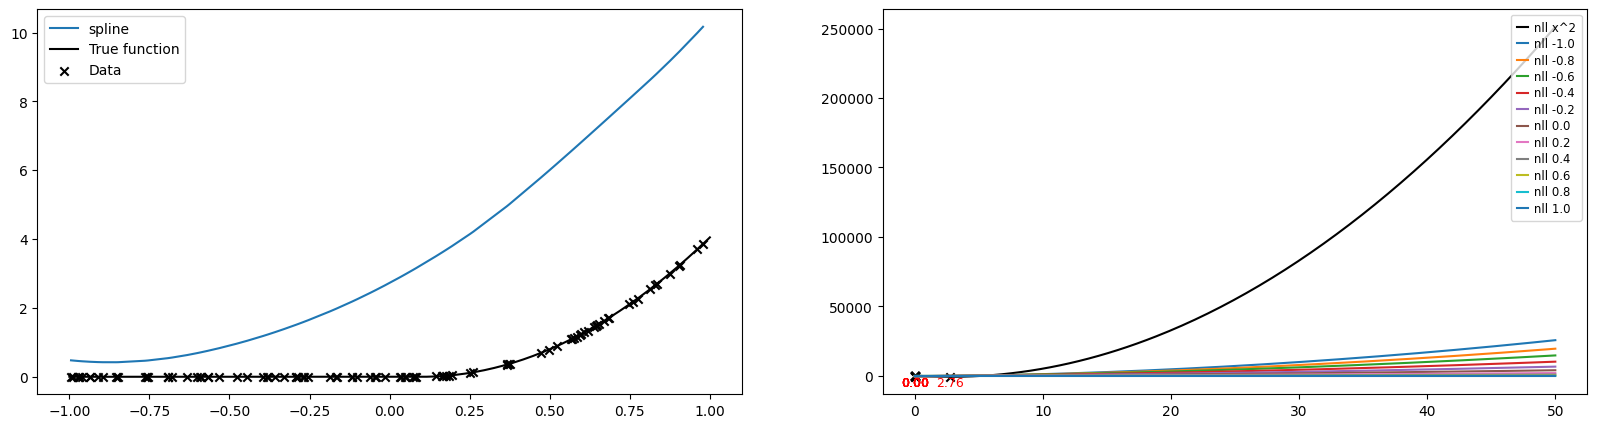

nll_at_left:278.2454706712151 > 0 knot_ind: 0
nll_at_right:1067361.443074935 > 0 knot_ind: 0
nll_at_right:95765.17375334774 > 0 knot_ind: 1
nll_at_right:70913.66057712228 > 0 knot_ind: 2
nll_at_right:51205.225087825354 > 0 knot_ind: 3
nll_at_right:34600.298026259195 > 0 knot_ind: 4
nll_at_right:21888.70732322428 > 0 knot_ind: 5
nll_at_right:12805.007625671606 > 0 knot_ind: 6
nll_at_right:6409.703493647679 > 0 knot_ind: 7
nll_at_right:2684.9977882907406 > 0 knot_ind: 8
nll_at_right:688.6918101694198 > 0 knot_ind: 9
nll_at_right:60.89379547543456 > 0 knot_ind: 10
curr g:	 [0.48 3.80 3.42 2.41 2.44 2.74 2.71 4.42 1.30 0.42 4.36 3.92]
curr w:	 [0.48 3.32 -0.39 -1.00 0.03 0.30 -0.02 1.71 -3.12 -0.89 3.94 -0.44]
best g:	 [2.76 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
best w:	 [2.76 -2.76 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]


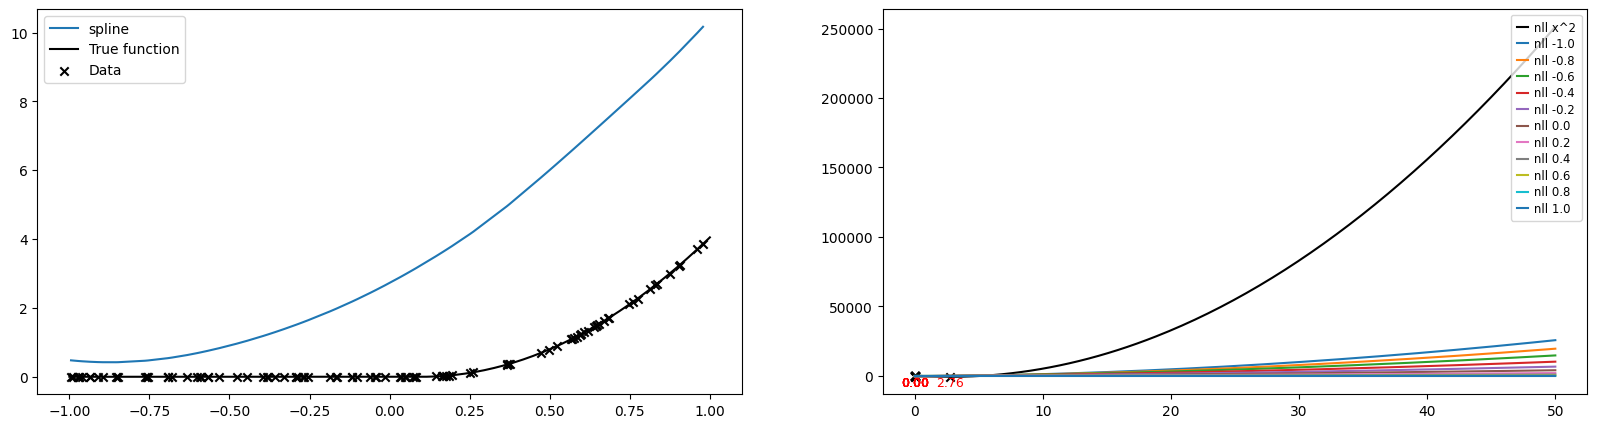

nll_at_left:277.8774437346773 > 0 knot_ind: 0
nll_at_right:1067361.0750479987 > 0 knot_ind: 0
nll_at_right:95764.80572641121 > 0 knot_ind: 1
nll_at_right:70913.29255018575 > 0 knot_ind: 2
nll_at_right:51204.85706088881 > 0 knot_ind: 3
nll_at_right:34599.92999932265 > 0 knot_ind: 4
nll_at_right:21888.339296287744 > 0 knot_ind: 5
nll_at_right:12804.639598735068 > 0 knot_ind: 6
nll_at_right:6409.335466711142 > 0 knot_ind: 7
nll_at_right:2684.6297613542024 > 0 knot_ind: 8
nll_at_right:688.323783232882 > 0 knot_ind: 9
nll_at_right:60.52576853889673 > 0 knot_ind: 10
curr g:	 [0.48 3.80 3.42 2.41 2.44 2.74 2.71 4.42 1.30 0.42 4.36 3.92]
curr w:	 [0.48 3.32 -0.39 -1.00 0.03 0.30 -0.02 1.71 -3.12 -0.89 3.94 -0.44]
best g:	 [2.76 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
best w:	 [2.76 -2.76 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]


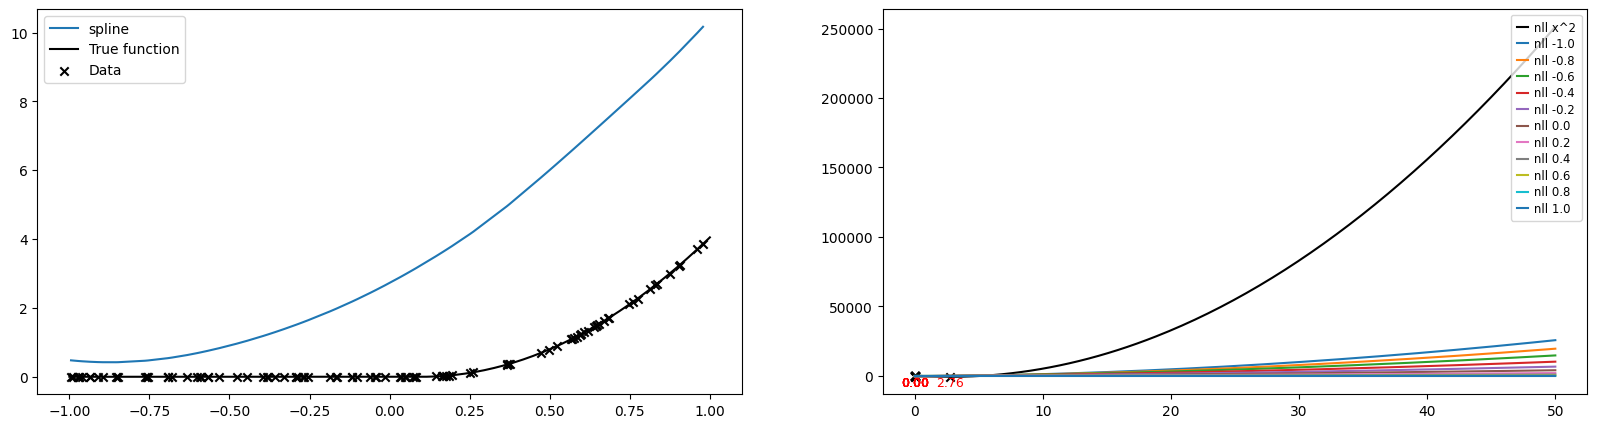

nll_at_left:204.33710643358387 > 0 knot_ind: 0
nll_at_right:1082591.178750844 > 0 knot_ind: 0
nll_at_right:91690.91919246459 > 0 knot_ind: 1
nll_at_right:67390.19613781029 > 0 knot_ind: 2
nll_at_right:50444.880413119885 > 0 knot_ind: 3
nll_at_right:32183.87901400137 > 0 knot_ind: 4
nll_at_right:20032.675082175654 > 0 knot_ind: 5
nll_at_right:12035.827310812681 > 0 knot_ind: 6
nll_at_right:5559.461709231702 > 0 knot_ind: 7
nll_at_right:2228.369628965669 > 0 knot_ind: 8
nll_at_right:535.4020451080987 > 0 knot_ind: 9
nll_at_right:41.53381675889801 > 0 knot_ind: 10
curr g:	 [0.48 3.80 3.42 0.00 2.44 2.74 0.00 4.42 1.30 0.42 4.36 3.92]
curr w:	 [0.48 3.32 -0.39 -3.42 2.44 0.30 -2.74 4.42 -3.12 -0.89 3.94 -0.44]
best g:	 [2.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
best w:	 [2.01 -2.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]


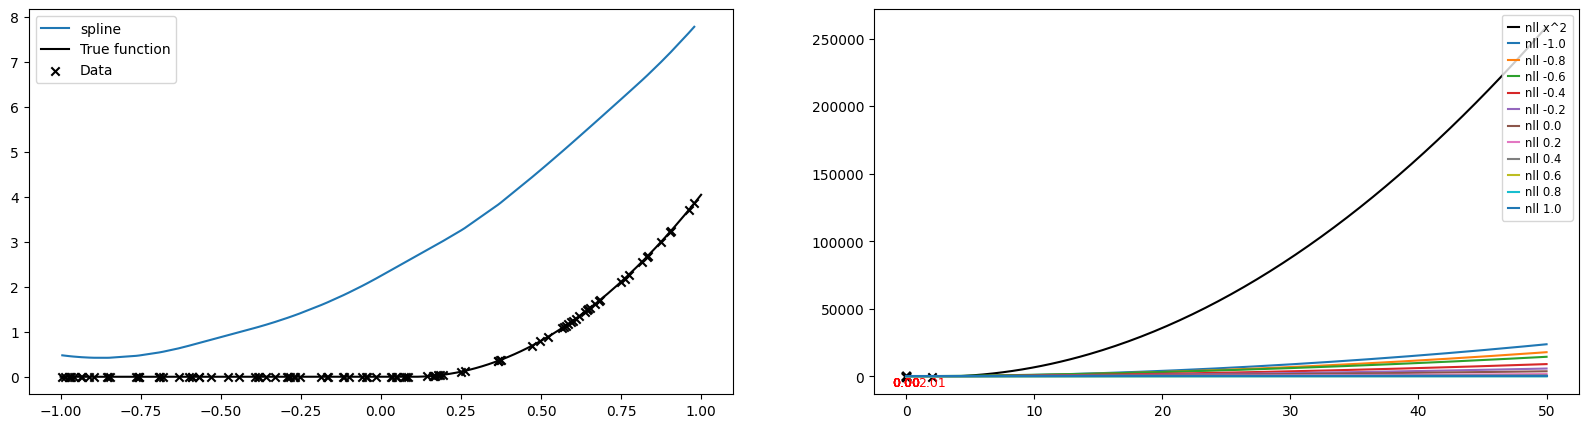

nll_at_left:203.51898616571043 > 0 knot_ind: 0
nll_at_right:1082590.3606305763 > 0 knot_ind: 0
nll_at_right:91690.10107219672 > 0 knot_ind: 1
nll_at_right:67389.37801754242 > 0 knot_ind: 2
nll_at_right:50444.06229285201 > 0 knot_ind: 3
nll_at_right:32183.0608937335 > 0 knot_ind: 4
nll_at_right:20031.856961907783 > 0 knot_ind: 5
nll_at_right:12035.009190544808 > 0 knot_ind: 6
nll_at_right:5558.643588963829 > 0 knot_ind: 7
nll_at_right:2227.5515086977957 > 0 knot_ind: 8
nll_at_right:534.5839248402252 > 0 knot_ind: 9
nll_at_right:40.71569649102457 > 0 knot_ind: 10
curr g:	 [0.48 3.80 3.42 0.00 2.44 2.74 0.00 4.42 1.30 0.42 4.36 3.92]
curr w:	 [0.48 3.32 -0.39 -3.42 2.44 0.30 -2.74 4.42 -3.12 -0.89 3.94 -0.44]
best g:	 [2.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
best w:	 [2.01 -2.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]


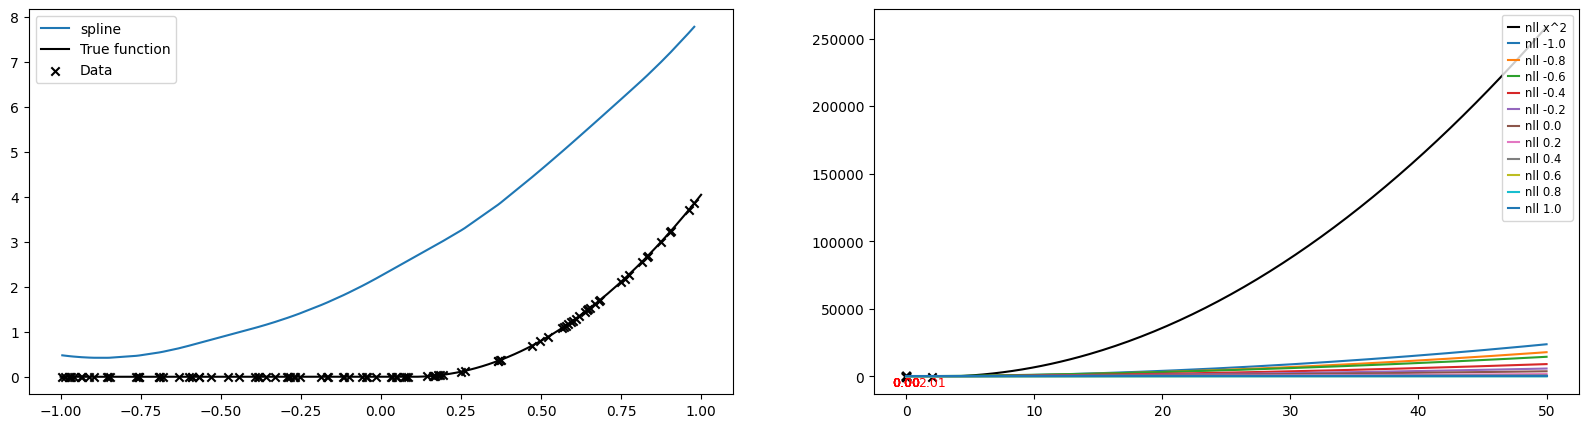

nll_at_left:204.39775719664664 > 0 knot_ind: 0
nll_at_right:1082591.239401607 > 0 knot_ind: 0
nll_at_right:91690.97984322764 > 0 knot_ind: 1
nll_at_right:67390.25678857334 > 0 knot_ind: 2
nll_at_right:50444.94106388295 > 0 knot_ind: 3
nll_at_right:32183.939664764435 > 0 knot_ind: 4
nll_at_right:20032.73573293872 > 0 knot_ind: 5
nll_at_right:12035.887961575743 > 0 knot_ind: 6
nll_at_right:5559.522359994765 > 0 knot_ind: 7
nll_at_right:2228.430279728732 > 0 knot_ind: 8
nll_at_right:535.4626958711615 > 0 knot_ind: 9
nll_at_right:41.59446752196078 > 0 knot_ind: 10
curr g:	 [0.48 3.80 3.42 0.00 2.44 2.74 0.00 4.42 1.30 0.42 4.36 3.92]
curr w:	 [0.48 3.32 -0.39 -3.42 2.44 0.30 -2.74 4.42 -3.12 -0.89 3.94 -0.44]
best g:	 [2.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
best w:	 [2.01 -2.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]


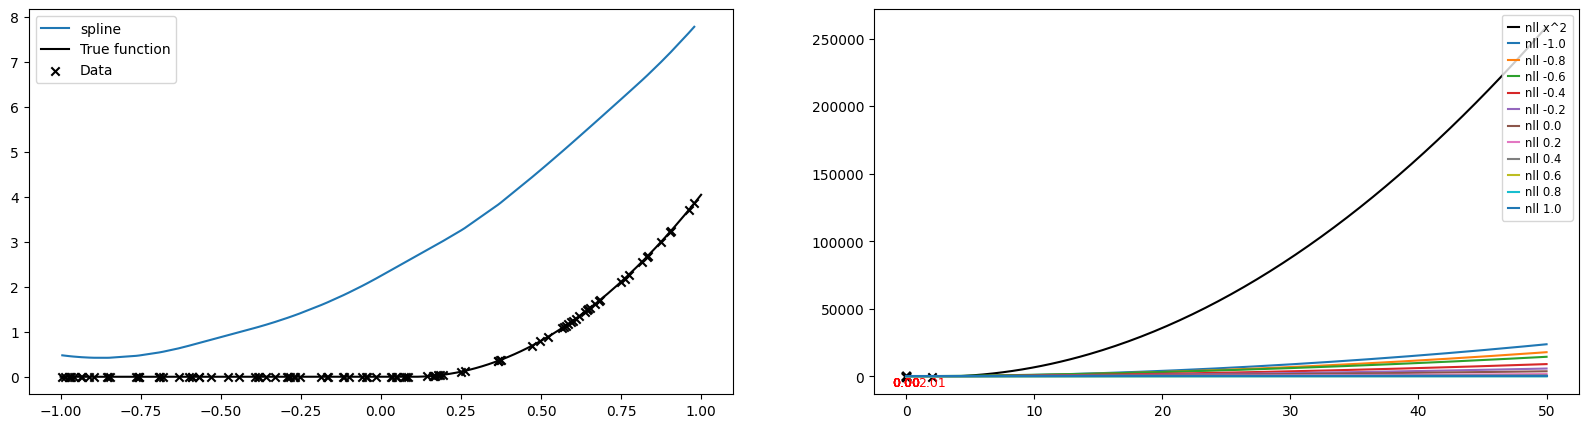

nll_at_left:204.0507976125249 > 0 knot_ind: 0
nll_at_right:1082671.9449164865 > 0 knot_ind: 0
nll_at_right:91670.90956986172 > 0 knot_ind: 1
nll_at_right:67372.37477772858 > 0 knot_ind: 2
nll_at_right:50428.77466919531 > 0 knot_ind: 3
nll_at_right:32170.460825834532 > 0 knot_ind: 4
nll_at_right:20021.583685436715 > 0 knot_ind: 5
nll_at_right:12026.770596676339 > 0 knot_ind: 6
nll_at_right:5553.055762847879 > 0 knot_ind: 7
nll_at_right:2224.070427094795 > 0 knot_ind: 8
nll_at_right:536.6746420491805 > 0 knot_ind: 9
nll_at_right:41.29929370603202 > 0 knot_ind: 10
curr g:	 [0.48 3.80 3.42 0.00 2.44 2.74 0.00 4.42 1.30 0.00 4.36 3.92]
curr w:	 [0.48 3.32 -0.39 -3.42 2.44 0.30 -2.74 4.42 -3.12 -1.30 4.36 -0.44]
best g:	 [2.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
best w:	 [2.01 -2.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]


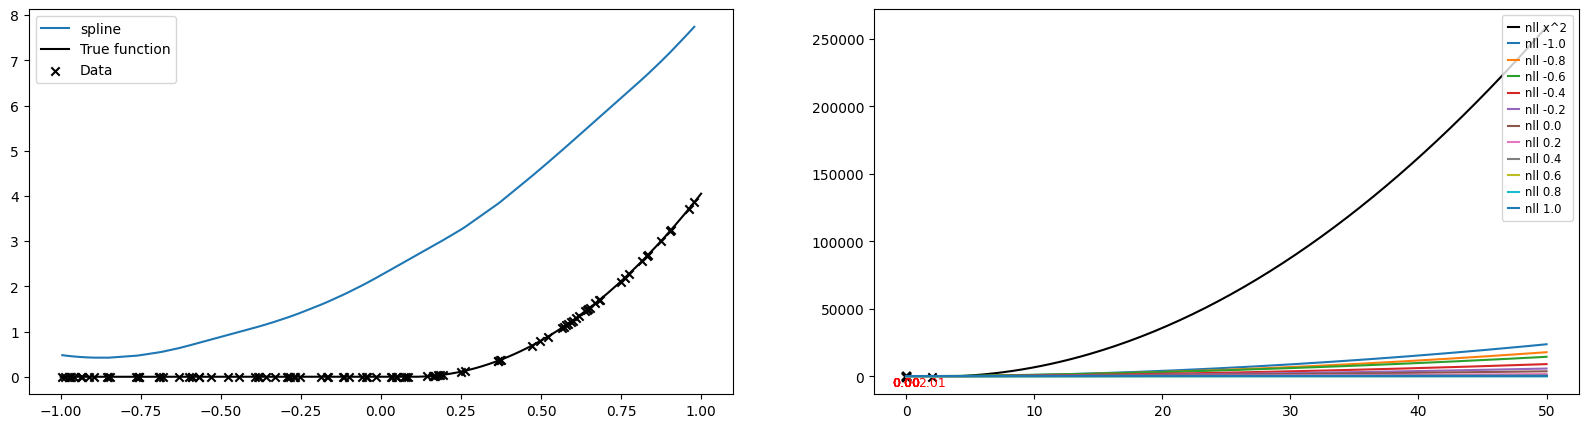

nll_at_left:203.89141154166748 > 0 knot_ind: 0
nll_at_right:1082671.7855304156 > 0 knot_ind: 0
nll_at_right:91670.75018379086 > 0 knot_ind: 1
nll_at_right:67372.21539165772 > 0 knot_ind: 2
nll_at_right:50428.61528312445 > 0 knot_ind: 3
nll_at_right:32170.301439763676 > 0 knot_ind: 4
nll_at_right:20021.42429936586 > 0 knot_ind: 5
nll_at_right:12026.61121060548 > 0 knot_ind: 6
nll_at_right:5552.896376777022 > 0 knot_ind: 7
nll_at_right:2223.9110410239377 > 0 knot_ind: 8
nll_at_right:536.5152559783231 > 0 knot_ind: 9
nll_at_right:41.13990763517461 > 0 knot_ind: 10
curr g:	 [0.48 3.80 3.42 0.00 2.44 2.74 0.00 4.42 1.30 0.00 4.36 3.92]
curr w:	 [0.48 3.32 -0.39 -3.42 2.44 0.30 -2.74 4.42 -3.12 -1.30 4.36 -0.44]
best g:	 [2.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
best w:	 [2.01 -2.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]


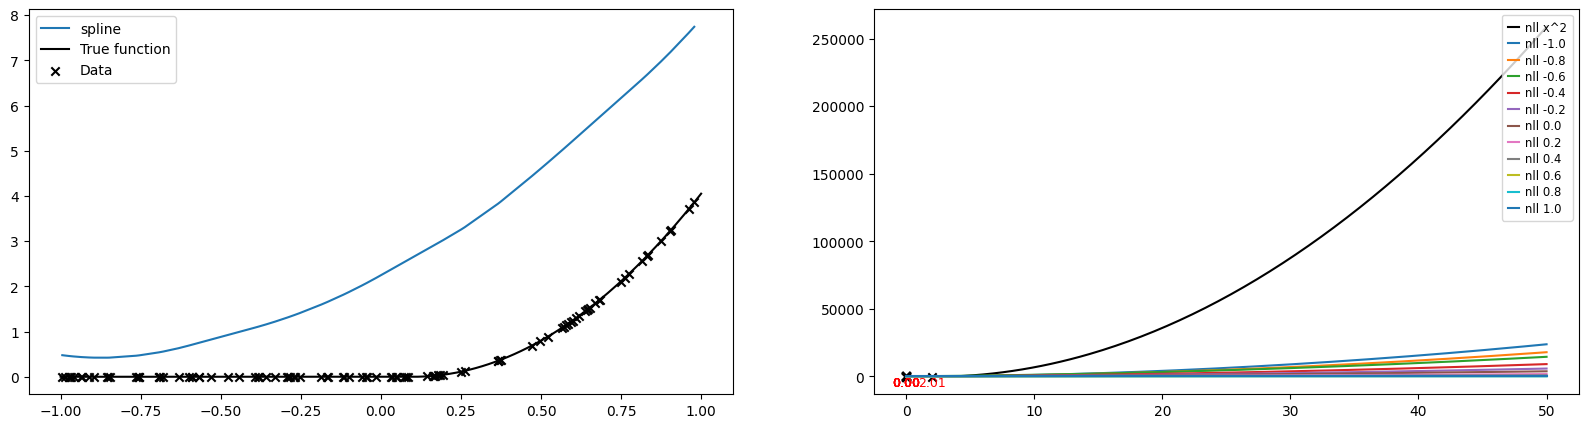

nll_at_left:203.98641979585415 > 0 knot_ind: 0
nll_at_right:1082671.8805386699 > 0 knot_ind: 0
nll_at_right:91670.84519204505 > 0 knot_ind: 1
nll_at_right:67372.3103999119 > 0 knot_ind: 2
nll_at_right:50428.71029137864 > 0 knot_ind: 3
nll_at_right:32170.396448017862 > 0 knot_ind: 4
nll_at_right:20021.519307620045 > 0 knot_ind: 5
nll_at_right:12026.706218859666 > 0 knot_ind: 6
nll_at_right:5552.991385031209 > 0 knot_ind: 7
nll_at_right:2224.0060492781245 > 0 knot_ind: 8
nll_at_right:536.6102642325097 > 0 knot_ind: 9
nll_at_right:41.234915889361275 > 0 knot_ind: 10
curr g:	 [0.48 3.80 3.42 0.00 2.44 2.74 0.00 4.42 1.30 0.00 4.36 3.92]
curr w:	 [0.48 3.32 -0.39 -3.42 2.44 0.30 -2.74 4.42 -3.12 -1.30 4.36 -0.44]
best g:	 [2.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
best w:	 [2.01 -2.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]


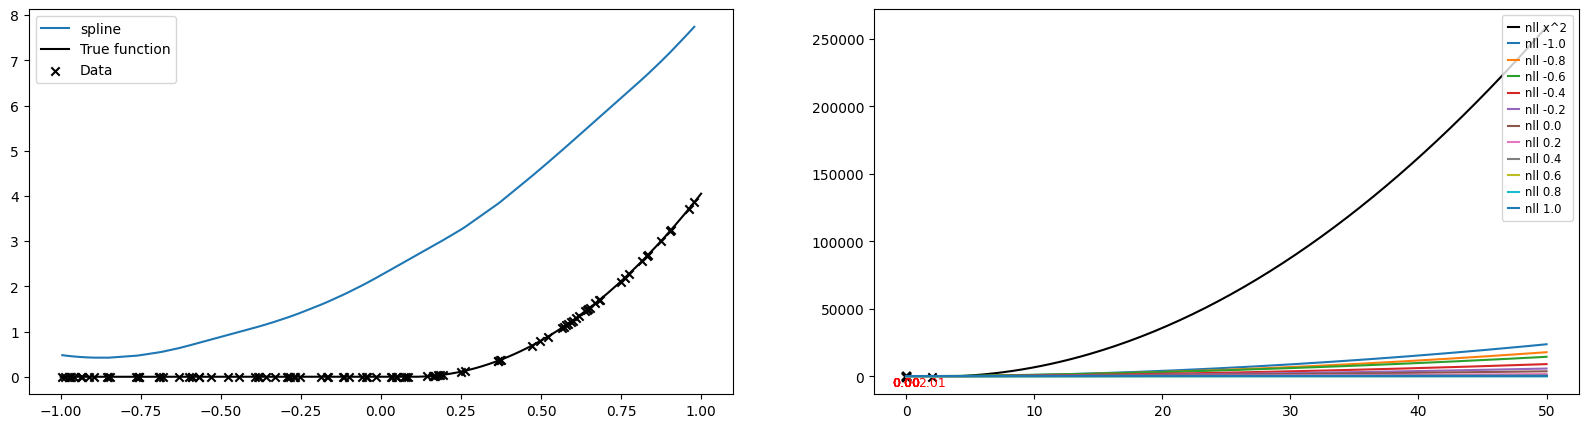

In [ ]:
def q_01_postive(x: np.ndarray) -> np.ndarray:
    return 5 * np.maximum(0, x - 0.1) ** 2


lin_slice = slice(0, 2)
x2_slice = slice(2, 3)
gamma_slice = slice(3, None)

n_knots = 11
interval = (-1, 1)

n_data = 100
xs, ys = sample_data(n_data, interval, q_01_postive, noise=0)
knots = np.linspace(*interval, n_knots)
features = spline_features(xs, knots)
gamma_max = 5
lin_max = 5
gamma = np.random.uniform(0, gamma_max, n_knots + 1)
lin_weight = np.random.uniform(-lin_max, lin_max, 2)
# test
lin_weight = np.zeros_like(lin_weight)

gamma_value_grid = np.linspace(0, 50, 200)
for opt_round in range(10):
    v_star = np.random.exponential(scale=1)
    base_nll = negative_ll_and_derivative(ys, features, lin_weight, gamma)
    v = v_star + base_nll

    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    plot_fun(
        create_weight(lin_weight, gamma),
        features,
        xs,
        true_fun=q_01_postive,
        data=np.column_stack((xs, ys)),
        interval=interval,
        ax=axs[0],
    )
    best_gamma_values = np.zeros_like(gamma)
    gamma_region = np.zeros((gamma.shape[0], 2))
    gamma_region[:, 0] = 0
    gamma_region[:, 1] = 100
    p_gamma_zero = 0.2
    nlls = np.zeros((n_knots + 1, gamma_value_grid.shape[0]))
    for knot_ind in range(0, gamma.shape[0]):
        # The following loop should be avoided in the end
        if True:
            for j, value in enumerate(gamma_value_grid):
                nll, der = negative_ll_and_derivative(
                    ys, features, lin_weight, gamma, index=knot_ind, value=value
                )
                nlls[knot_ind, j] = nll - v
            best_gamma_values[knot_ind] = gamma_value_grid[np.argmin(nlls[knot_ind])]
            axs[1].plot(
                gamma_value_grid,
                nlls[knot_ind],
                label=f"nll {np.round(knots[knot_ind-1], decimals=2) if knot_ind > 0 else 'x^2'}",
                color="black" if knot_ind == 0 else None,
            )
            # scatter the minimizer for each knot
            min_index = np.argmin(nlls[knot_ind])
            axs[1].scatter(
                gamma_value_grid[min_index],
                nlls[knot_ind, min_index],
                color="black",
                marker="x",
            )
            axs[1].vlines(
                x=gamma_value_grid[min_index],
                ymin=0,
                ymax=nlls[knot_ind, min_index],
                colors="gray",
                linestyles="dashed",
            )
            axs[1].text(
                gamma_value_grid[min_index],
                0,
                f"{gamma_value_grid[min_index]:.2f}",
                horizontalalignment="center",
                verticalalignment="top",
                fontsize=9,
                color="red",
            )
            axs[1].legend(
                loc="upper right",
                ncol=1,  # Change to more columns if needed, e.g., ncol=2
                fontsize="small",  # Smaller font size for compactness
                handlelength=1,  # Shorter line length in legend
                handletextpad=0.5,  # Reduced space between legend handle and text
                labelspacing=0.3,  # Reduced vertical spacing between entries
                borderpad=0.5,
            )
        # The actual computation of the region
        # This is a simple root finding algorithm
        should_be_disabled = False
        nll_at_left, left_der = negative_ll_and_derivative(
            ys,
            features,
            lin_weight,
            gamma,
            index=knot_ind,
            value=gamma_region[knot_ind, 0],
        )
        nll_at_right, right_der = negative_ll_and_derivative(
            ys,
            features,
            lin_weight,
            gamma,
            index=knot_ind,
            value=gamma_region[knot_ind, 1],
        )
        if nll_at_left - v > 0:
            print(f"nll_at_left:{nll_at_left - v} > 0", f"knot_ind: {knot_ind}")
        if nll_at_right - v > 0:
            print(f"nll_at_right:{nll_at_right - v} > 0", f"knot_ind: {knot_ind}")

    if True:
        print(
            "curr g:\t",
            np.array2string(gamma, formatter={"float_kind": lambda x: f"{x:.2f}"}),
        )
        print(
            "curr w:\t",
            np.array2string(
                create_weight(lin_weight, gamma)[2:],
                formatter={"float_kind": lambda x: f"{x:.2f}"},
            ),
        )
        print(
            "best g:\t",
            np.array2string(
                best_gamma_values, formatter={"float_kind": lambda x: f"{x:.2f}"}
            ),
        )
        print(
            "best w:\t",
            np.array2string(
                create_weight(lin_weight, best_gamma_values)[2:],
                formatter={"float_kind": lambda x: f"{x:.2f}"},
            ),
        )
    # test something
    # gamma[0] = best_gamma_values[0]
    # plot_fun(
    #     create_weight(lin_weight, gamma),
    #     features,
    #     xs,
    #     true_fun=q_01_postive,
    #     data=np.column_stack((xs, ys)),
    #     interval=interval,
    # )
    g = 0.05
    for knot_ind in range(1, gamma.shape[0]):
        t = np.random.uniform(0, 1)
        if t < g:
            gamma[knot_ind] = best_gamma_values[knot_ind]
    plt.show()

In [ ]:
n_knots = 11
interval = (-1, 1)
v_star = np.random.exponential(scale=1)

n_data = 100
xs, ys = sample_data(n_data, interval, q_01_postive, noise=0)
knots = np.linspace(*interval, n_knots)
features = spline_features(xs, knots)
gamma_max = 5
lin_max = 5
gamma = np.random.uniform(0, gamma_max, n_knots + 1)
lin_weight = np.random.uniform(-lin_max, lin_max, 2)

##### test
# lin_weight = np.zeros_like(lin_weight)
# gamma = np.zeros_like(gamma)
# # gamma[1:] = 5
# gamma[12:] = 5
# w = create_weight(lin_weight, gamma)
# print(w[lin_slice])
# print(w[x2_slice])
# print(w[gamma_slice])
plot_fun(
    create_weight(lin_weight, gamma),
    features,
    xs,
    true_fun=q_01_postive,
    data=np.column_stack((xs, ys)),
    interval=interval,
)
# print(f"v_star: {v_star}")

base_nll = negative_ll_and_derivative(ys, features, lin_weight, gamma)
v = v_star + base_nll

grid = np.linspace(0, 100, 200)
plt.figure(figsize=(20, 5))
for ind in range(1, gamma.shape[0]):
    nlls = np.zeros_like(grid)
    for j, value in enumerate(grid):
        nll, der = negative_ll_and_derivative(
            ys, features, lin_weight, gamma, index=ind, value=value
        )
        nlls[j] = nll - v
    plt.plot(
        grid,
        nlls,
        label=f"nll {np.round(knots[ind-1], decimals=2) if ind > 0 else 'x^2'}",
        color="black" if ind == 0 else None,
    )
    # scatter the minimizer for each knot
    min_index = np.argmin(nlls)
    plt.scatter(grid[min_index], nlls[min_index], color="black", marker="x")
    # add a point on x-axis for each minimizer
    plt.vlines(
        x=grid[min_index],
        ymin=0,
        ymax=nlls[min_index],
        colors="gray",
        linestyles="dashed",
    )
    # Annotate the x-value at the bottom (x-axis)
    plt.text(
        grid[min_index],
        0,
        f"{grid[min_index]:.2f}",
        horizontalalignment="center",
        verticalalignment="top",
        fontsize=9,
        color="red",
    )
plt.legend(
    loc="upper right",
    ncol=1,  # Change to more columns if needed, e.g., ncol=2
    fontsize="small",  # Smaller font size for compactness
    handlelength=1,  # Shorter line length in legend
    handletextpad=0.5,  # Reduced space between legend handle and text
    labelspacing=0.3,  # Reduced vertical spacing between entries
    borderpad=0.5,
)
plt.title(f"Index {ind}")
plt.show()

In [ ]:
def sample(
    x_data: np.ndarray,
    y_data: np.ndarray,
    knots: np.ndarray,
    bias_init: float,
    linear_init: float,
    gamma_init: np.ndarray,
    mask: np.ndarray,
    n_burn_in: int,
    noise_std: float,
    p_mask: float,
    tau: float,
    root_finding_trials: int,
):
    bias = bias_init
    linear = linear_init
    gamma = gamma_init
    features = spline_features(x_data, knots)
    for i in range(n_burn_in):
        # Compute the negative log likelihood assuming the noise is Gaussian
        weights = create_weight(gamma, [bias, linear])
        # apply the mask
        prediction = features @ (weights * mask)
        data_log_likelihood = np.sum((y_data - prediction) ** 2) / (2 * noise_std**2)

        # Make v
        v_star = np.random.exponential(scale=1)
        v = v_star - data_log_likelihood

        # Generate new gamma and mask using the Metropolis-Hastings algorithm
        new_gamma = np.copy(gamma)
        new_mask = np.copy(mask)
        for j in range(gamma.shape[0]):
            # Find the region that nll - v is negative
            # Since nll is convex in weights[j], and we have access to the derivative
            # we can use the derivative to find the region where nll - v is negative
            # by taking the steps like: a_min = a_min - (nll(a_min) - v) / nll'(a_min)
            a_min, a_max = 0, 1000
            # First make sure that nll(a_max) - v is positive
            while (
                negative_ll_and_derivative(j, a_max, y_data, features, weights)[0] - v
                < 0
            ):
                a_max *= 2
            nll_a_min, derivative_a_min = negative_ll_and_derivative(
                j, a_min, y_data, features, weights
            )
            nll_a_max, derivative_a_max = negative_ll_and_derivative(
                j, a_max, y_data, features, weights
            )
            for _ in range(root_finding_trials):
                flag = False
                if nll_a_min - v > 1e-6:
                    flag = True
                    a_min = a_min - (nll_a_min - v) / derivative_a_min
                    nll_a_min, derivative_a_min = negative_ll_and_derivative(
                        j, a_min, y_data, features, weights
                    )
                if nll_a_max - v > 1e-6:
                    flag = True
                    a_max = a_max - (nll_a_max - v) / derivative_a_max
                    nll_a_max, derivative_a_max = negative_ll_and_derivative(
                        j, a_max, y_data, features, weights
                    )
                if not flag:
                    break
                if a_min < 0:
                    a_min = 0
                if a_max < a_min + 1e-6:
                    flag = True
                    break
            if flag:
                new_gamma[j] = 0
                new_mask[j] = 0
            else:
                is_masked = np.random.binomial(1, p_mask)
                if is_masked:
                    new_gamma[j] = a_min
                    new_mask[j] = 0
                    continue
                else:
                    # Sample from a truncated normal distribution with mean 0 and std tau truncated to [a_min, a_max]
                    while True:
                        a = scipy.stats.truncnorm.rvs(
                            (a_min - 0) / tau, (a_max - 0) / tau, loc=0, scale=tau
                        )
                        nll_a, der_a = negative_ll_and_derivative(
                            j, a, y_data, features, weights
                        )
                        if nll_a - v < 0:
                            break
                        else:
                            if der_a > 0:
                                a_max = a
                            else:
                                a_min = a
                    new_gamma[j] = a
                    new_mask[j] = 1
        gamma = new_gamma
        mask = new_mask
    return gamma, mask


# test
xs, ys, features, knots = sample_data()
weight = sample_weight(n_knots=knots.shape[0])
mask = np.random.binomial(1, 0.7, weight.shape[0])
gamma, mask = sample(
    xs,
    ys,
    knots,
    weight[0],
    weight[1],
    weight[2:],
    mask,
    n_burn_in=1000,
    noise_std=0.1,
    p_mask=0.2,
    tau=1,
    root_finding_trials=10,
)